In [1]:
import numpy as np
from scipy.optimize import curve_fit
import datetime
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [2]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [3]:
# saving account, you can use personal token if signed up to IBMQ
rio_token = 'f152f464304e59d406b3447be9e43866d55fabd52d333a2b505eff11c292dae2d2fd1f59457f82bf5517df24a3ed7038db086ed5f01906a254dbbe437110f246'
#IBMQ.save_account(rio_token)
# load account, provider and backend
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')

In [4]:
backend_sim = 'ibmq_qasm_simulator'
backends = ["ibmq_santiago", "ibmq_manila", "ibmq_bogota", "ibmq_casablanca"]

job_manager = IBMQJobManager()
backend = provider.get_backend(backends[0])

print(backend)

ibmq_santiago


In [5]:
# parameters for transpiling and running jobs
best_qubits = None
shots_num = 8000
n = 5

In [6]:
# Circuits for measurement error mitigations
qc_err = qiskit.QuantumRegister(n)
meas_calibs, state_labels = complete_meas_cal(qr=qc_err, circlabel='mcal')
meas_calibs = transpile(meas_calibs, backend=backend, initial_layout=best_qubits)
job_err = qiskit.execute(meas_calibs, backend=backend, shots=shots_num)
job_monitor(job_err)
print('All jobs have finished.')

Job Status: job has successfully run
All jobs have finished.


In [7]:
cal_result = job_err.result()

In [8]:
meas_fitter = CompleteMeasFitter(cal_result, state_labels, circlabel='mcal')
cal_matrix = meas_fitter.cal_matrix
fidel_vals = np.diagonal(cal_matrix)

In [9]:
# Fitting function
def to_fit(meas, fa0, fa1, fb0, fb1, fc0, fc1, fd0, fd1, fe0, fe1):
    wave_a = (fa0 - fa1) * np.array([1 if t % 2 == 0 else 0 for t in meas]) + fa1  # Square wave with period 2, corresponding to fidelity of first qubit
    wave_b = (fb0 - fb1) * np.array([1 if (t//2) % 2 == 0 else 0 for t in meas]) + fb1
    wave_c = (fc0 - fc1) * np.array([1 if (t//4) % 2 == 0 else 0 for t in meas]) + fc1
    wave_d = (fd0 - fd1) * np.array([1 if (t//8) % 2 == 0 else 0 for t in meas]) + fd1
    wave_e = (fe0 - fe1) * np.array([1 if (t//16) % 2 == 0 else 0 for t in meas]) + fe1
    return wave_a * wave_b * wave_c * wave_d * wave_e

In [10]:
initguess = 0.99*np.ones(10)
errors = 0.1*np.ones(32)
outcomes = np.linspace(0, 31, 32)

In [11]:
popt, pcov = curve_fit(to_fit, outcomes, fidel_vals, initguess, errors, bounds = (0, 1))
print(popt)

[0.99266142 0.94592147 0.99037067 0.98232278 0.98893583 0.97702219
 0.99048154 0.98247056 0.99609178 0.96564208]


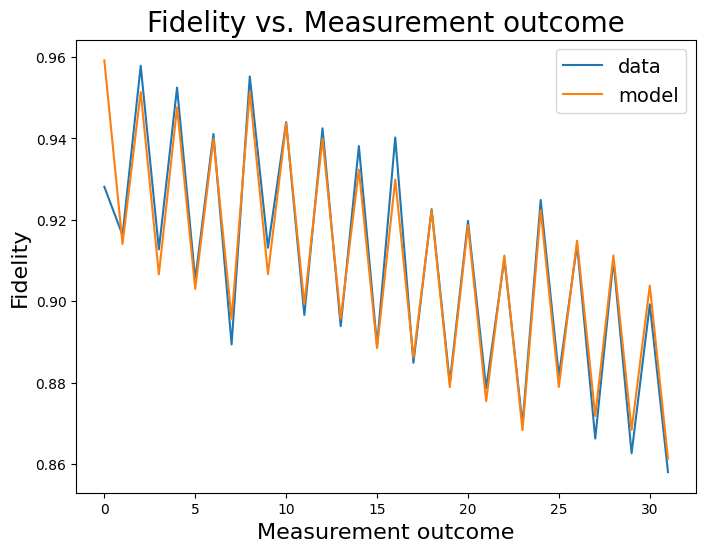

In [12]:
plt.plot(outcomes, fidel_vals, label = "data")
plt.plot(outcomes, to_fit(outcomes, *popt), label = "model")
plt.xlabel("Measurement outcome", size = 16)
plt.ylabel("Fidelity", size = 16)
plt.legend(loc = "best", prop={'size': 14})
plt.title("Fidelity vs. Measurement outcome", size = 20)
#plt.savefig("Errorfitting.pdf")
plt.show()

In [13]:
i = 0
while i < len(popt):
    for j in range(2):
        print("Measurement fidelity for outcome " + str(j) + " on qubit " + str((i + 2)//2) + " is " + str(np.round(popt[i], 4)))
        i += 1

Measurement fidelity for outcome 0 on qubit 1 is 0.9927
Measurement fidelity for outcome 1 on qubit 1 is 0.9459
Measurement fidelity for outcome 0 on qubit 2 is 0.9904
Measurement fidelity for outcome 1 on qubit 2 is 0.9823
Measurement fidelity for outcome 0 on qubit 3 is 0.9889
Measurement fidelity for outcome 1 on qubit 3 is 0.977
Measurement fidelity for outcome 0 on qubit 4 is 0.9905
Measurement fidelity for outcome 1 on qubit 4 is 0.9825
Measurement fidelity for outcome 0 on qubit 5 is 0.9961
Measurement fidelity for outcome 1 on qubit 5 is 0.9656


Next, we do this the simpler and arguably more legitimate way, where we look at 10 different circuits that test the measurement statistics of each qubit individually.

In [14]:
qc_list = []

for i in range(2 * n):
    qc = QuantumCircuit(5, 1)
    qubit = i // 2
    if i % 2 == 1:
        qc.x(qubit)
    qc.measure(qubit, 0)
    print(qc.draw())
    qc_list.append(qc)

     ┌─┐
q_0: ┤M├
     └╥┘
q_1: ─╫─
      ║ 
q_2: ─╫─
      ║ 
q_3: ─╫─
      ║ 
q_4: ─╫─
      ║ 
c: 1/═╩═
      0 
     ┌───┐┌─┐
q_0: ┤ X ├┤M├
     └───┘└╥┘
q_1: ──────╫─
           ║ 
q_2: ──────╫─
           ║ 
q_3: ──────╫─
           ║ 
q_4: ──────╫─
           ║ 
c: 1/══════╩═
           0 
        
q_0: ───
     ┌─┐
q_1: ┤M├
     └╥┘
q_2: ─╫─
      ║ 
q_3: ─╫─
      ║ 
q_4: ─╫─
      ║ 
c: 1/═╩═
      0 
             
q_0: ────────
     ┌───┐┌─┐
q_1: ┤ X ├┤M├
     └───┘└╥┘
q_2: ──────╫─
           ║ 
q_3: ──────╫─
           ║ 
q_4: ──────╫─
           ║ 
c: 1/══════╩═
           0 
        
q_0: ───
        
q_1: ───
     ┌─┐
q_2: ┤M├
     └╥┘
q_3: ─╫─
      ║ 
q_4: ─╫─
      ║ 
c: 1/═╩═
      0 
             
q_0: ────────
             
q_1: ────────
     ┌───┐┌─┐
q_2: ┤ X ├┤M├
     └───┘└╥┘
q_3: ──────╫─
           ║ 
q_4: ──────╫─
           ║ 
c: 1/══════╩═
           0 
        
q_0: ───
        
q_1: ───
        
q_2: ───
     ┌─┐
q_3: ┤M├
     └╥┘
q_4: ─╫─
      ║ 
c: 1

In [15]:
qc_list_trans = transpile(qc_list, backend=backend, initial_layout=best_qubits)
job_exp = job_manager.run(qc_list_trans, backend=backend, shots=shots_num, name='error_parameter_extraction')
for i in range(len(job_exp.jobs())):
    job_monitor(job_exp.jobs()[i])
print('All jobs have finished.')

Job Status: job has successfully run
All jobs have finished.


In [16]:
exp_result = job_exp.results()

In [17]:
fidel_params = []
for k in range(len(qc_list)):
    result = exp_result.get_counts(k)
    if k % 2 == 0:
        fidel = result.get("0")/shots_num
    else:
        fidel = result.get("1")/shots_num
    fidel_params.append(fidel)

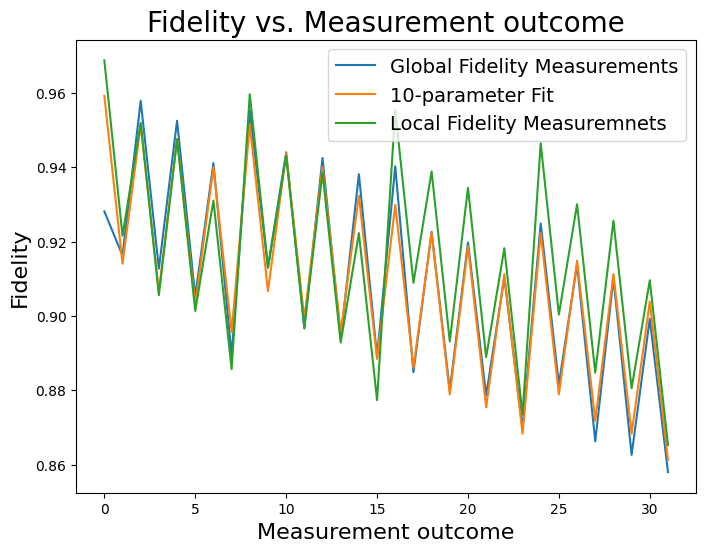

In [20]:
plt.plot(outcomes, fidel_vals, label = "Global Fidelity Measurements")
plt.plot(outcomes, to_fit(outcomes, *popt), label = "10-parameter Fit")
plt.plot(outcomes, to_fit(outcomes, *fidel_params), label = "Local Fidelity Measuremnets")
plt.xlabel("Measurement outcome", size = 16)
plt.ylabel("Fidelity", size = 16)
plt.legend(loc = "best", prop={'size': 14})
plt.title("Fidelity vs. Measurement outcome", size = 20)
plt.savefig("Errormodelfit2.pdf")
plt.show()

In [19]:
i = 0
while i < len(fidel_params):
    for j in range(2):
        print("Measurement fidelity for outcome " + str(j) + " on qubit " + str((i + 2)//2) + " is " + str(np.round(fidel_params[i], 4)))
        i += 1

Measurement fidelity for outcome 0 on qubit 1 is 0.991
Measurement fidelity for outcome 1 on qubit 1 is 0.9428
Measurement fidelity for outcome 0 on qubit 2 is 0.9948
Measurement fidelity for outcome 1 on qubit 2 is 0.9775
Measurement fidelity for outcome 0 on qubit 3 is 0.9954
Measurement fidelity for outcome 1 on qubit 3 is 0.9735
Measurement fidelity for outcome 0 on qubit 4 is 0.9969
Measurement fidelity for outcome 1 on qubit 4 is 0.9875
Measurement fidelity for outcome 0 on qubit 5 is 0.9904
Measurement fidelity for outcome 1 on qubit 5 is 0.9768
